In [1]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rnd
import cmath as cmath
import scipy.optimize as opt
import getpass
#Import the needed libraries

In [2]:
user = getpass.getuser()

In [3]:
defaultpath='C:/Users/{}/Documents/FiguresKuramoto/'.format(user)

In [4]:
#Initialization values so I can demonstrate the code; there is a one-line-call function at the end of the notebook
#which allows one to run a full simulation with arbitrary parameters and display the results
N = 50 #Number of oscillators
K = 20 #Coupling strength constant
h = 5 #Forcing function strength
D = 2 #Noise parameter
tau = 1 #NEVER SET tau to 0 or it will ALL break
tf=20 #Final time
dt = 1e-3 #Time step; it's probably best to set this around 1e-2 in order not to wait an inordinate amount of time
#no accuracy error was observed in trial runs between 1e-2 and 1e-3 (I mean some, certainly, but the results seem good)
modelparameters=[N,K,h,D,tf,tau,dt] #A model of how one should define this array

In [5]:
#Stochastic noise process; D is a dimension parameter which we may control; Note that white noise in a discrete 
#process such as this is simply interpreted as being drawn from a Gaussian distribution; credit: random obscure 
#Stackoverflow thread
def zetta(t,D):
    return rnd.normal(0,scale = 2*D)

In [6]:
#A function to get the solution state a given time; may be used if desired; note: not actually used but I think
#it's a clever function; I shouldn't write code when tired should I?
def get_y(y,t,dt=1e-3):
    return y[int(t/dt)]

In [7]:
#Initial phases theta0s and natural frequencies omegai; For illustration purposes
theta0s = rnd.uniform(0.0,2*np.pi,size=N)
omegais = rnd.uniform(0.0,2*np.pi,size=N)

In [8]:
#Function to integrate the equation including the stochastic noise and delay
#The bread and butter of the project; this actually does all the work; is it crappy code? Probably; Does it work? Yes
def integrate_euler(modelparams,theta0s=theta0s,omegais=omegais,t0=0):
    N,K,h,D,tf,tau,dt = modelparams
    print("Using K = {} N = {}\n".format(K,N))
    thetas = theta0s #Take thetas to be the initial values
    times=[] #The time array
    t=0 #We start at t=0
    times.append(t) #Add it to array
    while (t<tau): #We integrate "blindly" until tau
        thetas = np.vstack((thetas,theta0s)) #Just assume initial phases; We can do this because we want the 
        #Time evolution eventually
        t+=dt 
        times.append(t)
    t=tau #Now we start at tau
    while(t<tf-dt):
        thetas_now = thetas[-1] #Current oscillator state
        thetas_past = thetas[int((t-tau)/dt)] #State at t' = t_current - tau
        newthetas=np.zeros(shape=N) #We will store the new thetas here
        for i in range(N):
            #Advance the value step
            newthetas[i] = thetas_now[i]+(omegais[i]+zetta(t,D)+h*np.sin(thetas_now[i])+K/N*sum(np.sin(thetas_past[j]-thetas_now[i]) for j in range(N)))*dt
        thetas = np.vstack((thetas,newthetas)) #Now append the new thetas to the original array
        t+=dt #Advance time
        times.append(t) #And add it
    return (times,thetas) #Return a tuple containing times and thetas; thetas[i] 
                          #returns the state of the system at t[i]

In [9]:
#The parameters we use to investigate the system numerically
N = 100 #Oscillator number
K = 0.2 #Coupling strength
h = 3 #Forcing function strength
tau = 1 #Time delay
D = 4 #Noise parameter; controls noise spread
tf=30 #Up until which time we integrate
dt = 1e-2 #The time step
modelparameters=[N,K,h,D,tf,tau,dt]
#--------->
#Initial values
theta0s = rnd.uniform(0.0,2*np.pi,size=N) 
omegais = rnd.uniform(0.0,2*np.pi,size=N)

In [10]:
#Get some solutions
t,y = integrate_euler(modelparameters,theta0s,omegais,t0=0)

Using K = 0.2 N = 100



In [11]:
#See if the order parameter thing still makes sense
sols = y #The solution states
averages = [np.average(sols[i]) for i in range(len(sols))] #Getting averages
ordparams = [] #Will store order parameter values in here
for i in range(len(sols)):
    ordparams.append((1/N)*sum(cmath.exp(1j*sols[i][k]) for k in range(N))) #Getting the nasty complex stuff
rs = []
for i in range(len(ordparams)):
    rs.append(cmath.polar(ordparams[i])[0]) #And turning it into polar so I can get stuff
reals = [k.real for k in ordparams] #Note sure why I wanted these, but I did
imgs = [k.imag for k in ordparams]

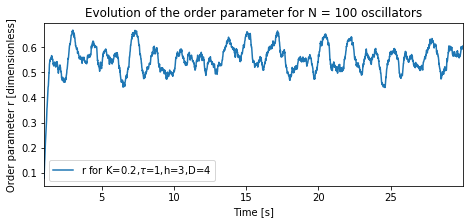

In [12]:
#Here we plot the evolution of the order parameter
fig = plt.figure(figsize=(7.5,3))
frame = fig.add_subplot(1,1,1)
frame.plot(t,rs,label="r for K={},$\\tau$={},h={},D={}".format(K,tau,h,D))
frame.set_xlabel("Time [s]")
frame.set_ylabel("Order parameter r [dimensionless]")
frame.set_title("Evolution of the order parameter for N = {} oscillators".format(N))
frame.legend()
frame.set_xlim(tau,max(t))
fig.savefig(defaultpath+'catz.png')

In [13]:
#Analytical calculations
#First the N=2 case

In [14]:
#Take some coupling strength and time delay; these are preselected because the root-finding function is awful
K = 3
tau = 2
N=2
h = 0
D = 0 
dt=1e-2
modelparameters=[N,K,h,D,tf,tau,dt]

In [15]:
#omega1,omega2 = rnd.uniform(0,2*np.pi,size=2)
omega1,omega2 = (1.2,0.8)#Take some arbitrary natural frequencies; again, predefined because f(omega) is terrible
domega = omega1-omega2 #As defined in the paper
Kc = domega
baromega = (omega1+omega2)/2 #As defined in the paper
def func_root(Omega):
    return baromega - Omega - K/2 * np.tan(Omega*tau)*(np.cos(Omega*tau)**2-(Kc/(K))**2)**0.5
def alpha(Omega):
    if(np.cos(Omega*tau)>0):
        return np.arcsin(domega/(K*np.cos(Omega*tau)))
    else:
        return np.pi-np.arcsin(domega/(K*np.cos(Omega*tau)))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


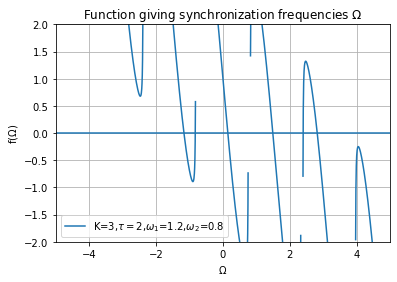

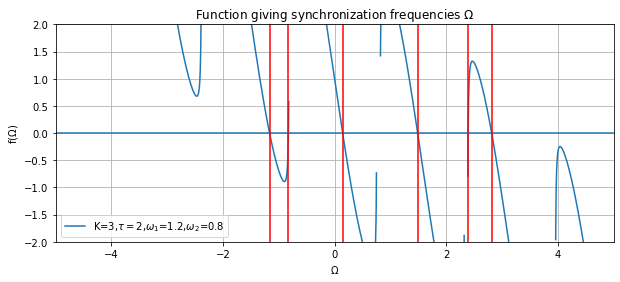

In [16]:
domega = omega1-omega2 #As defined in the paper
Kc = domega/2
baromega = (omega1+omega2)/2 #As defined in the paper
def func_root(Omega):
    return baromega - Omega - K * np.tan(Omega*tau)*(np.cos(Omega*tau)**2-(Kc/K)**2)**0.5
def alpha(Omega):
    if(np.cos(Omega*tau)>0):
        return np.arcsin(domega/(K*np.cos(Omega*tau)))
    else:
        return np.pi-np.arcsin(domega/(K*np.cos(Omega*tau)))
#Visualisation to help in finding the roots Omegai
par = np.linspace(-20,20,10000)
fig = plt.figure()
frame = fig.add_subplot(1,1,1)
frame.plot(par,func_root(par),label="K={},$\\tau={}$,$\omega_1$={},$\omega_2$={}".format(K,tau,omega1,omega2))
frame.set_xlim(-5,5)
frame.set_ylim(-2,2)
frame.axhline(0)
frame.set_xlabel("$\Omega$")
frame.set_ylabel("f($\Omega$)")
frame.set_title("Function giving synchronization frequencies $\Omega$")
frame.legend()
frame.grid()
Omegas = opt.fsolve(func_root,[-1.8,-0.83,2.2,2.5,2.4,3.2])
#Visualisation to help in finding the roots Omegai
par = np.linspace(-20,20,10000)
fig = plt.figure(figsize=(10,4))
frame = fig.add_subplot(1,1,1)
frame.plot(par,func_root(par),label="K={},$\\tau={}$,$\omega_1$={},$\omega_2$={}".format(K,tau,omega1,omega2))
frame.set_xlim(-5,5)
frame.set_ylim(-2,2)
frame.axhline(0)
for j in range(len(Omegas)):
    frame.axvline(Omegas[j],color='red')
frame.grid()
frame.set_xlabel("$\Omega$")
frame.set_ylabel("f($\Omega$)")
frame.set_title("Function giving synchronization frequencies $\Omega$")
frame.legend(loc='lower left')
fig.savefig(defaultpath+'rootcat.png')

In [17]:
Omegas

array([-1.16518208, -0.82757026,  0.14488445,  1.4887792 ,  2.39390325,
        2.81530055])

In [18]:
K = 3
tau = 2
N=2
h = 0
D = 0 
dt=1e-2
modelparameters=[N,K,h,D,tf,tau,dt] #Just to be safe and stuff
omega1,omega2 = (1.2,0.8) #Must be the predefined ones in this case
omegais = np.array([omega1,omega2])
theta0s=np.array([-0.1,2.5]) #This bit isn't as important; i.e. one could use random stuff here

In [19]:
t1,y1 = integrate_euler(modelparameters,theta0s,omegais,t0=0)
t1 = np.array(t1)

Using K = 3 N = 2



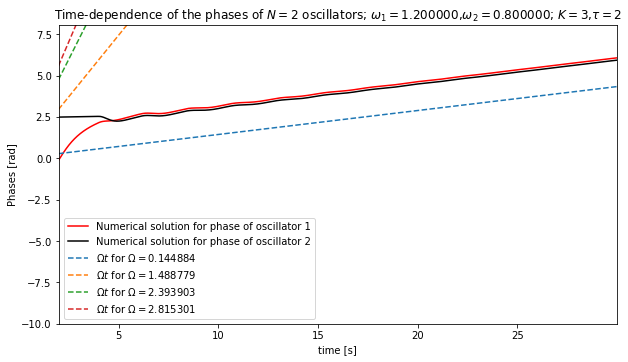

In [20]:
fig = plt.figure(figsize=(10,5.5))
frame = fig.add_subplot(1,1,1)
frame.plot(t1,y1[:,0],color='red',label="Numerical solution for phase of oscillator 1")
frame.plot(t1,y1[:,1],color='black',label="Numerical solution for phase of oscillator 2")
frame.set_xlabel("time [s]")
frame.set_ylabel("Phases [rad]")
frame.set_xlim(tau,max(t1))
frame.set_ylim(-10,y1.max()+2)
for j in range(len(Omegas)):
    if(Omegas[j]>0):
        frame.plot(t1,Omegas[j]*t1,linestyle='dashed',label="$\Omega t$ for $\Omega={:f}$".format(Omegas[j]))
frame.legend(loc="lower left")
frame.set_title("Time-dependence of the phases of $N={}$ oscillators; $\omega_1 = {:2f}$,$\omega_2={:1f}$; $K={}$,$\\tau={}$".format(N,omega1,omega2,K,tau))
fig.savefig(defaultpath+"mycat"+".png")
#Yay it works they synchronize to the expected frequency. The offset is busted, though. 

Using K = 3 N = 2

Using K = 3 N = 2

Using K = 3 N = 2

Using K = 3 N = 2



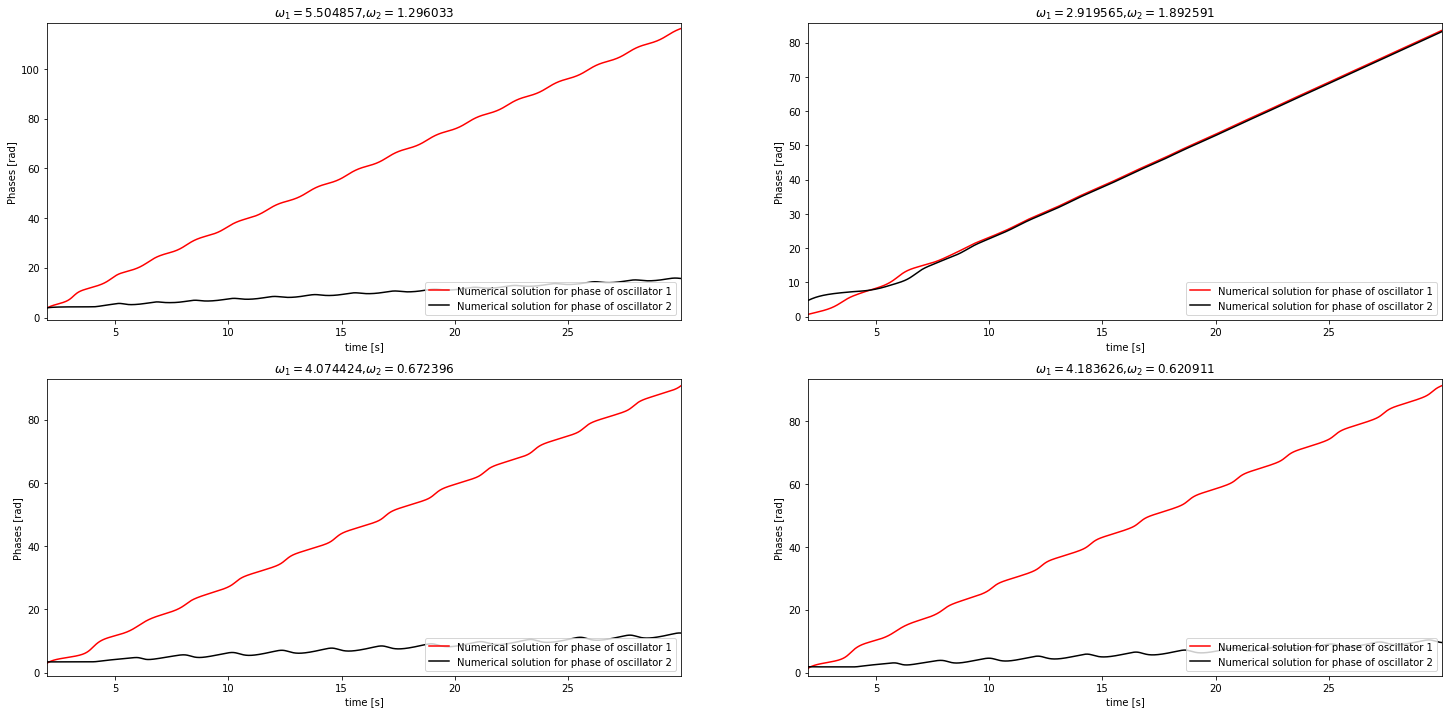

In [21]:
#Now let's look at random stuff; There is a one-line function for this as well!
fig = plt.figure(figsize=(25,12))
for figno in range(4):
    omega1,omega2= rnd.uniform(0,2*np.pi,size=2)
    omegais = np.array([omega1,omega2])
    theta0s=rnd.uniform(0,2*np.pi,size=2)
    t1,y1 = integrate_euler(modelparameters,theta0s,omegais,t0=0)
    t1 = np.array(t1)
    frame = fig.add_subplot(2,2,figno+1)
    frame.plot(t1,y1[:,0],color='red',label="Numerical solution for phase of oscillator 1")
    frame.plot(t1,y1[:,1],color='black',label="Numerical solution for phase of oscillator 2")
    frame.set_xlabel("time [s]")
    frame.set_ylabel("Phases [rad]")
    frame.set_xlim(tau,max(t1))
    frame.set_ylim(-1,y1.max()+2)
#for j in range(len(Omegas)):
#    if(Omegas[j]>0):
 #       frame.plot(t1,Omegas[j]*t1,linestyle='dashed',label="$\Omega t$ for $\Omega={:f}$".format(Omegas[j]))
    frame.legend(loc="lower right")
    frame.set_title("$\omega_1 = {:2f}$,$\omega_2={:1f}$".format(omega1,omega2))
    fig.savefig(defaultpath+"randomcatzzz.png")

(2, 29.99000000000189)

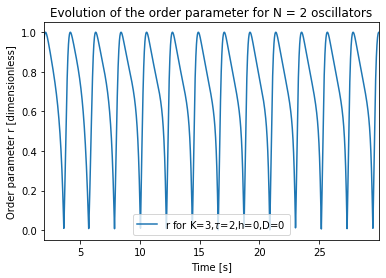

In [22]:
#See if the order parameter thing still makes sense
sols = y1
t=t1
averages = [np.average(sols[i]) for i in range(len(sols))]
ordparams = []
for i in range(len(sols)):
    ordparams.append((1/N)*sum(cmath.exp(1j*sols[i][k]) for k in range(N)))
rs = []
for i in range(len(ordparams)):
    rs.append(cmath.polar(ordparams[i])[0])
reals = [k.real for k in ordparams]
imgs = [k.imag for k in ordparams]
#Here we plot the evolution of the order parameter
fig = plt.figure()
frame = fig.add_subplot()
frame.plot(t,rs,label="r for K={},$\\tau$={},h={},D={}".format(K,tau,h,D))
frame.set_xlabel("Time [s]")
frame.set_ylabel("Order parameter r [dimensionless]")
frame.set_title("Evolution of the order parameter for N = {} oscillators".format(N))
frame.legend()
frame.set_xlim(tau,max(t1))

In [23]:
#### FOR N = 3 ####

In [24]:
#Parameters
N=3
D = 0
K=4
h = 0
tau=1
tf=20
dt=1e-2
modelparameters=[N,K,h,D,tf,tau,dt]

#Initial conditions
omega1,omega2,omega3 = rnd.uniform(0,2*np.pi,size=N)
omegais = np.array([omega1,omega2,omega3])
theta0s=np.array([-0.1,2.5,1.2])



In [25]:
t1,y1 = integrate_euler(modelparameters,theta0s,omegais,t0=0)
t1 = np.array(t1)

Using K = 4 N = 3



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  


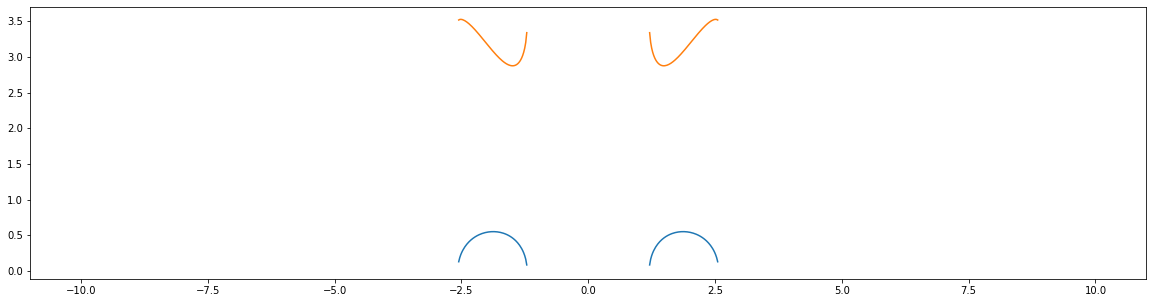

In [26]:
#Let's do some guessing and see if we can find some analytical Omegas
### Trying to find the synchronization frequencies graphically
baromega = (omega1+omega2+omega3)/3

b = lambda alpha: np.sin(alpha/2)+np.sin(alpha)

def g(alpha):
    return (4*K**2/9 - (omega3-omega1)**2/b(alpha)**2)**0.5

alpha = np.linspace(-10,10,1000)
fig = plt.figure(figsize=(20,5))
frame = fig.add_subplot(1,1,1)
frame.plot(alpha,1/tau * np.arcsin(3/(2*K)*g(alpha)))
frame.plot(alpha,baromega-(np.cos(alpha)+2*np.cos(alpha/2))/3*g(alpha))

alpharoots = [-3,-0.75,.65,1.95] #These are guesses

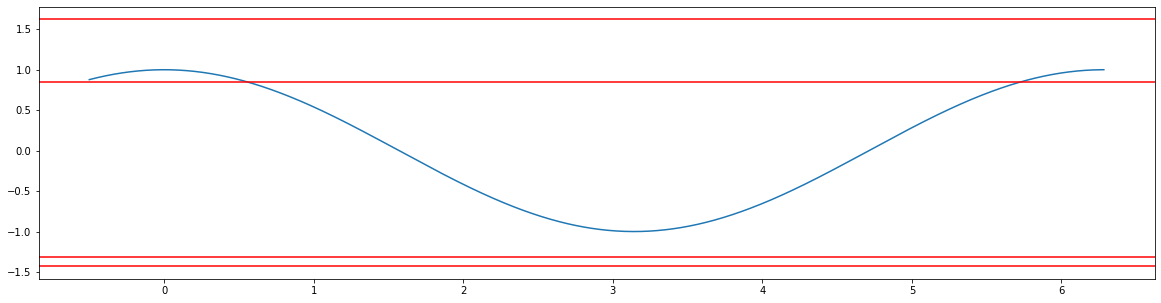

In [27]:
Omegatest = np.linspace(-0.5,2*np.pi,1000)
fig = plt.figure(figsize=(20,5))
frame = fig.add_subplot(1,1,1)
frame.plot(Omegatest,np.cos(Omegatest*tau))
for root in alpharoots:
    frame.axhline(-3/(2*K)*(omega3-omega1)/b(root),color='red')
Omegaroots = [0.36] #Don't want negatives here, so just guessing positives

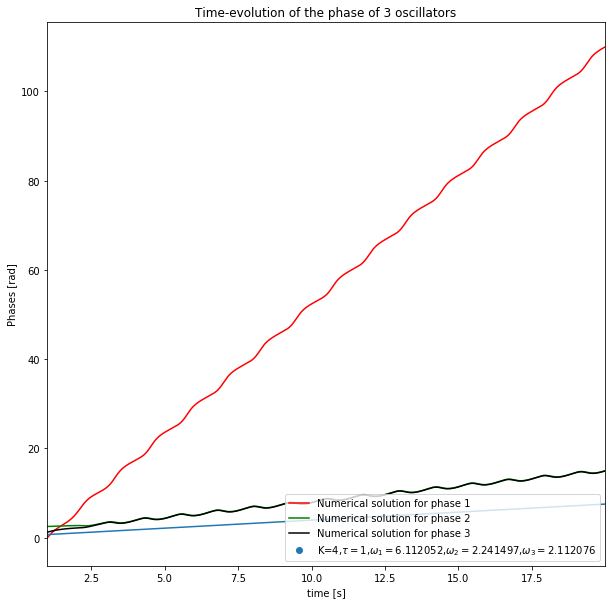

In [28]:
#Let's check it out

#Plotting
fig = plt.figure(figsize=(10,10))
frame = fig.add_subplot(1,1,1)
frame.plot(t1,y1[:,0],color='red',label="Numerical solution for phase 1")
frame.scatter(t1[0],y1[0,0],label="K={},$\\tau={}$,$\omega_1={:3f}$,$\omega_2={:3f}$,$\omega_3={:3f}$".format(K,tau,omega1,omega2,omega3))
frame.plot(t1,y1[:,1],color='green',label="Numerical solution for phase 2")
frame.plot(t1,y1[:,2],color='black',label="Numerical solution for phase 3")
for root in Omegaroots:
    frame.plot(t1,root*t1+0.65/2)
frame.set_xlabel("time [s]")
frame.set_ylabel("Phases [rad]")
frame.set_xlim(tau,max(t1))
frame.legend(loc = 'lower right')
frame.set_title("Time-evolution of the phase of 3 oscillators")
fig.savefig(defaultpath+"Somerandomstuff.png")

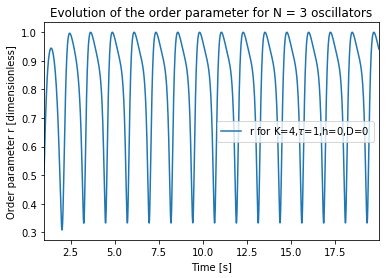

In [29]:
#See if the order parameter thing still makes sense
sols = y1
t=t1
averages = [np.average(sols[i]) for i in range(len(sols))]
ordparams = []
for i in range(len(sols)):
    ordparams.append((1/N)*sum(cmath.exp(1j*sols[i][k]) for k in range(N)))
rs = []
for i in range(len(ordparams)):
    rs.append(cmath.polar(ordparams[i])[0])
reals = [k.real for k in ordparams]
imgs = [k.imag for k in ordparams]
#Here we plot the evolution of the order parameter
fig = plt.figure()
frame = fig.add_subplot()
frame.plot(t,rs,label="r for K={},$\\tau$={},h={},D={}".format(K,tau,h,D))
frame.set_xlabel("Time [s]")
frame.set_ylabel("Order parameter r [dimensionless]")
frame.set_title("Evolution of the order parameter for N = {} oscillators".format(N))
frame.legend()
frame.set_xlim(tau,max(t1))
fig.savefig(defaultpath+"Sketch.png")

Using K = 4 N = 3

Using K = 4 N = 3

Using K = 4 N = 3

Using K = 4 N = 3



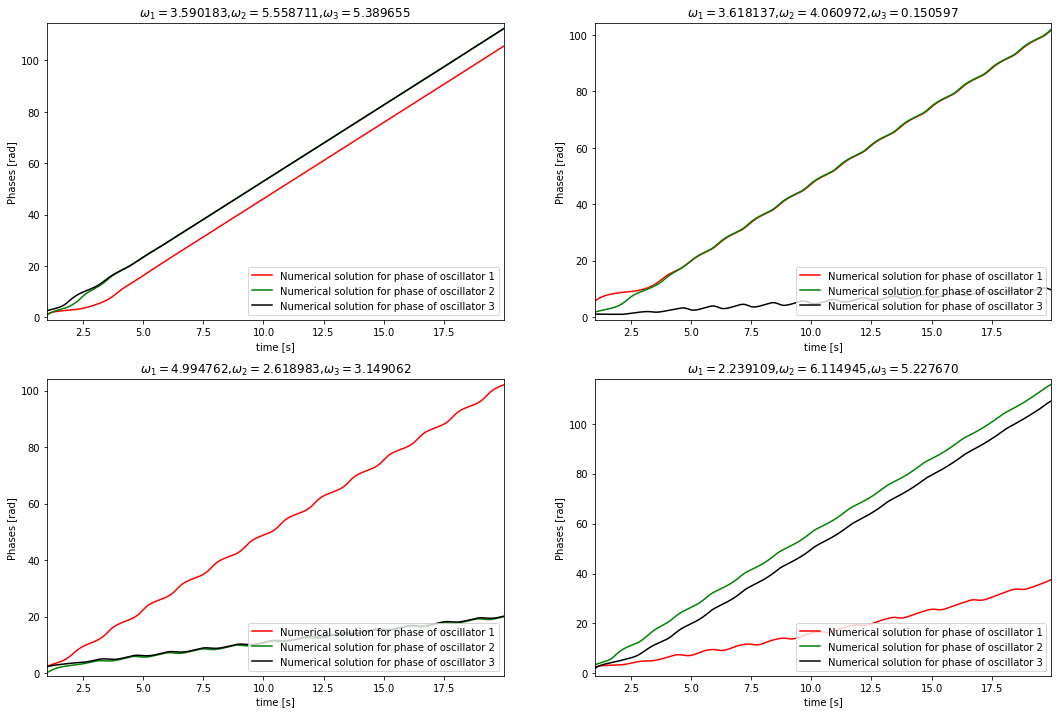

In [30]:
#Random simulations; these are easily obtained in large quantities using the functions at the end of the notebook.
fig = plt.figure(figsize=(18,12))
for figno in range(4):
    N=3
    omega1,omega2,omega3 = rnd.uniform(0,2*np.pi,size=N)
    omegais = np.array([omega1,omega2,omega3])
    theta0s=rnd.uniform(0,2*np.pi,size=N)
    t1,y1 = integrate_euler(modelparameters,theta0s,omegais,t0=0)
    t1 = np.array(t1)
    frame = fig.add_subplot(2,2,figno+1)
    frame.plot(t1,y1[:,0],color='red',label="Numerical solution for phase of oscillator 1")
    frame.plot(t1,y1[:,1],color='green',label="Numerical solution for phase of oscillator 2")
    frame.plot(t1,y1[:,2],color='black',label="Numerical solution for phase of oscillator 3")
    frame.set_xlabel("time [s]")
    frame.set_ylabel("Phases [rad]")
    frame.set_xlim(tau,max(t1))
    frame.set_ylim(-1,y1.max()+2)
#for j in range(len(Omegas)):
#    if(Omegas[j]>0):
 #       frame.plot(t1,Omegas[j]*t1,linestyle='dashed',label="$\Omega t$ for $\Omega={:f}$".format(Omegas[j]))
    frame.legend(loc="lower right")
    frame.set_title("$\omega_1 = {:2f}$,$\omega_2={:1f}$,$\omega_3={:1f}$".format(omega1,omega2,omega3))
    fig.savefig(defaultpath+"Caties.png")

In [31]:
######
#                      <--------- THE EASY-TO-USE ONE-LINE FUNCTIONS START HERE ------->

In [32]:
#This function creates argand digrams at the specified time
def get_argand_diagrams(N,y,time,filename="Argand",path=defaultpath):
    sols = get_y(y,time,dt=1e-2)
    thetas=np.array(sols)
    points = np.exp(1j*thetas)
    reals = [k.real for k in points]
    imgs = [k.imag for k in points]
    fig = plt.figure(figsize=(5,5))
    frame=fig.add_subplot(1,1,1)
    frame.scatter(reals,imgs)
    frame.set_xlim(-1.2,1.2)
    frame.set_ylim(-1.2,1.2)
    frame.set_xlabel("Re($e^{\\theta_i}$)")
    frame.set_ylabel("Im($e^{\\theta_i}$)")
    frame.set_title("Argand diagram of the phases at t={}".format(time))
    fig.savefig(path+filename+"{}".format(time)+".png")
def get_argand_diagrams_systematic(N,y,time,parameters,filename="sim",path=defaultpath):
    K,h,D,tau,tf,dt = parameters
    sols = get_y(y,time,dt=1e-2)
    thetas=np.array(sols)
    points = np.exp(1j*thetas)
    reals = [k.real for k in points]
    imgs = [k.imag for k in points]
    fig = plt.figure(figsize=(5,5))
    frame=fig.add_subplot(1,1,1)
    frame.scatter(reals,imgs)
    frame.set_xlim(-1.2,1.2)
    frame.set_ylim(-1.2,1.2)
    frame.set_xlabel("Re($e^{\\theta_i}$)")
    frame.set_ylabel("Im($e^{\\theta_i}$)")
    frame.set_title("Argand diagram of the phases at t={}".format(time))
    fig.savefig(path+filename+"Argand"+"_N{}".format(N)+"_K{}".format(K)+"_D{}_".format(D)+"h{}_".format(h)+"tau_".format(tau)+"tf{}_".format(tf)+"dt{}_".format(dt)+"time{}".format(time)+".png")
    plt.close()

In [33]:
def get_order_parameter_plot(N,K,h,D,tau,tf,dt,filename="testing.png",path=defaultpath,figuresize=(7.5,3),output=False):
    modelparameters=[N,K,h,D,tf,tau,dt]
    theta0s = rnd.uniform(0.0,2*np.pi,size=N) 
    omegais = rnd.uniform(0.0,2*np.pi,size=N)
    print("You have selected the parameters:K={},N={},h={},D={},tau={},tf={},dt={}\nProceeding\n".format(K,N,h,D,tau,tf,dt))
    t,y = integrate_euler(modelparameters,theta0s,omegais,t0=0)
    sols = y #The solution states
    averages = [np.average(sols[i]) for i in range(len(sols))] #Getting averages
    ordparams = [] #Will store order parameter values in here
    for i in range(len(sols)):
        ordparams.append((1/N)*sum(cmath.exp(1j*sols[i][k]) for k in range(N))) #Getting the nasty complex stuff
    rs = []
    for i in range(len(ordparams)):
        rs.append(cmath.polar(ordparams[i])[0]) #And turning it into polar so I can get stuff
    reals = [k.real for k in ordparams] #Note sure why I wanted these, but I did
    imgs = [k.imag for k in ordparams]
    fig = plt.figure(figsize=figuresize)
    frame = fig.add_subplot()
    frame.plot(t,rs,label="r for K={},$\\tau$={},h={},D={}".format(K,tau,h,D))
    frame.set_xlabel("Time [s]")
    frame.set_ylabel("Order parameter r [dimensionless]")
    frame.set_title("Evolution of the order parameter for N = {} oscillators".format(N))
    frame.legend()
    frame.set_xlim(tau,max(t))
    fig.savefig(path+filename)
    if(output):
        return(t,y)

In [34]:
def get_order_parameter_plot_from_dataset(dataset,parameters,filename ='testing1',path=defaultpath,figuresize=(25,12)):
    t,y = dataset
    sols = y #The solution states
    N = len(y[0])
    K,h,D,tau,tf,dt = parameters
    averages = [np.average(sols[i]) for i in range(len(sols))] #Getting averages
    ordparams = [] #Will store order parameter values in here
    for i in range(len(sols)):
        ordparams.append((1/N)*sum(cmath.exp(1j*sols[i][k]) for k in range(N))) #Getting the nasty complex stuff
    rs = []
    for i in range(len(ordparams)):
        rs.append(cmath.polar(ordparams[i])[0]) #And turning it into polar so I can get stuff
    reals = [k.real for k in ordparams] #Note sure why I wanted these, but I did
    imgs = [k.imag for k in ordparams]
    fig = plt.figure(figsize=figuresize)
    frame = fig.add_subplot()
    frame.plot(t,rs,label="r")
    frame.set_xlabel("Time [s]",fontsize=40)
    frame.set_ylabel("Order parameter r [dimensionless]",fontsize=40)
    frame.set_title("Evolution of the order parameter for N = {} oscillators".format(N),fontsize=40)
    frame.legend()
    frame.set_xlim(tau,max(t))
    frame.tick_params(axis='both',labelsize=40)
    frame.annotate("K={},h={},D={},$\\tau$={}".format(K,h,D,tau),(tau,min(rs)),fontsize=20)
    fig.savefig(path+filename+".png")
    

In [35]:
#How to use get_order_parameter_plot:
#Simply ask the function to simulate the model with the desired parameters
#The signature is
#get_order_parameter_plot(Number of oscillators, Coupling strength, forcing strength, noise parameter, delay,
#final time, time step, name of file - put in '', path to save the figure - use ''; figure size - use (x,y))

You have selected the parameters:K=10,N=2,h=3,D=1,tau=10,tf=50,dt=0.01
Proceeding

Using K = 10 N = 2



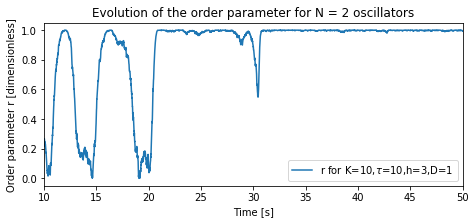

In [36]:
t1,y1=get_order_parameter_plot(2,10,3,1,10,50,1e-2,output=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


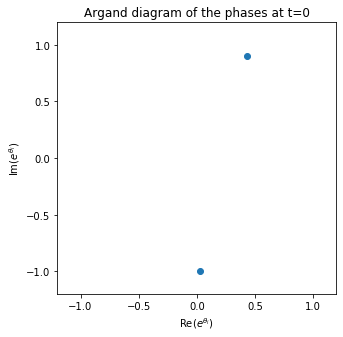

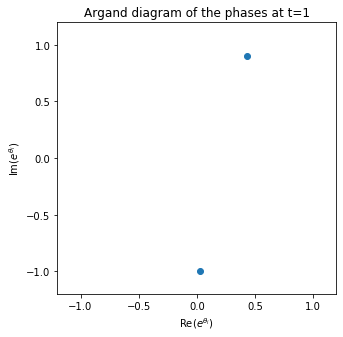

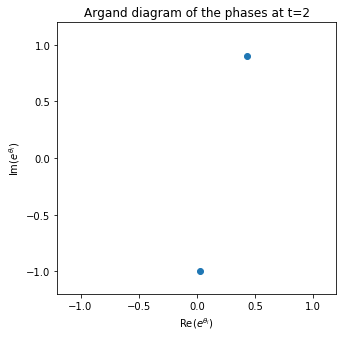

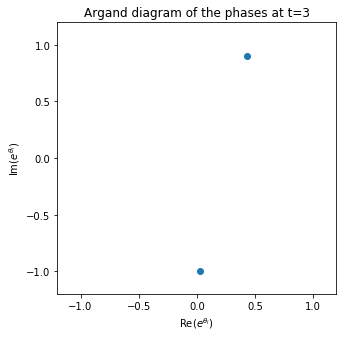

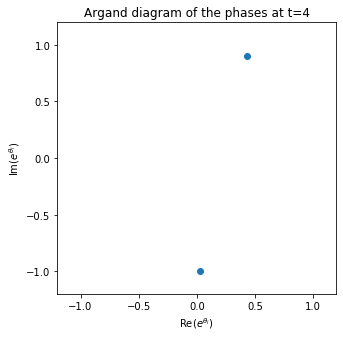

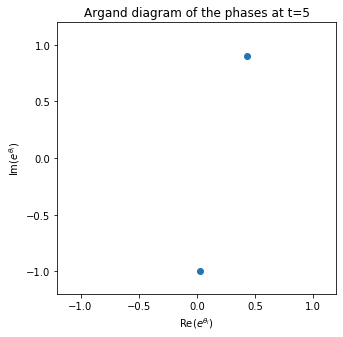

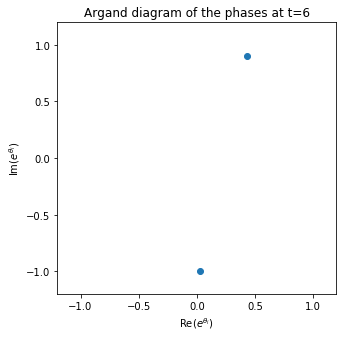

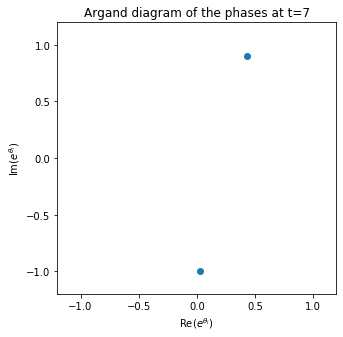

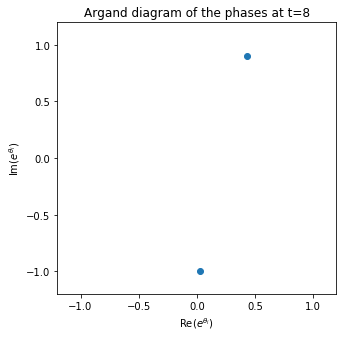

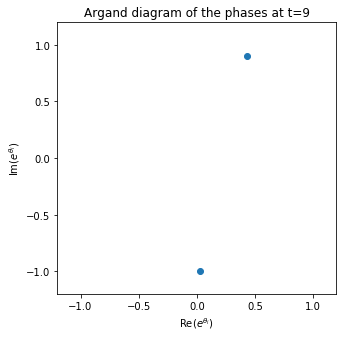

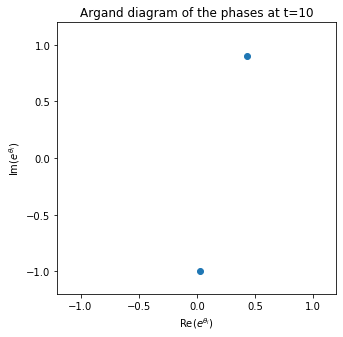

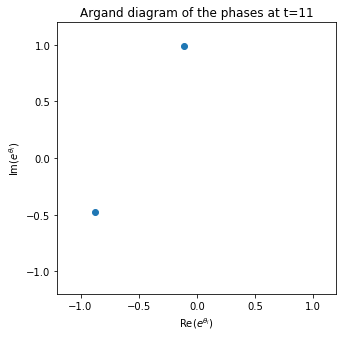

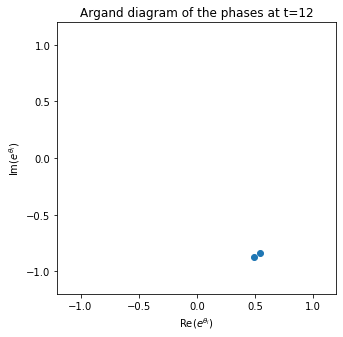

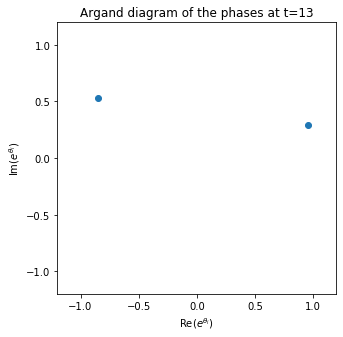

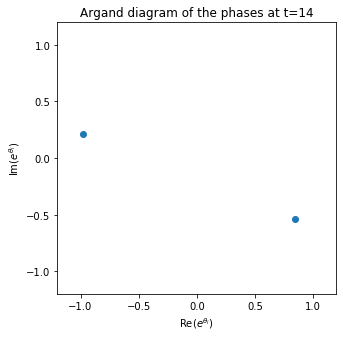

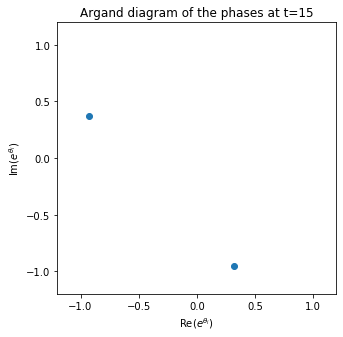

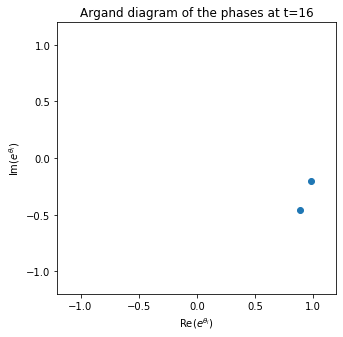

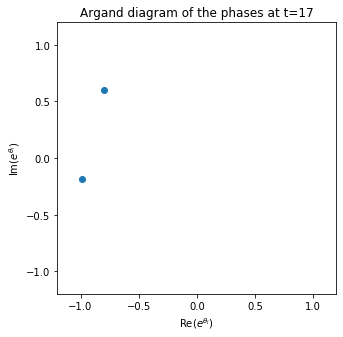

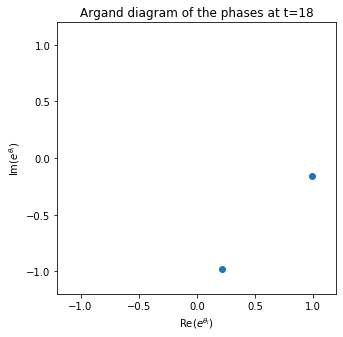

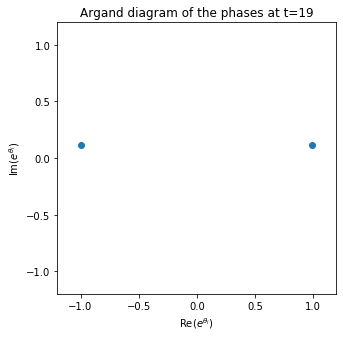

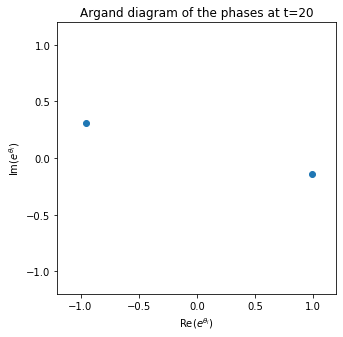

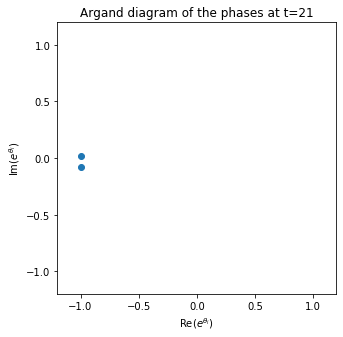

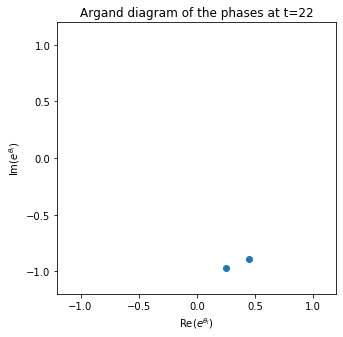

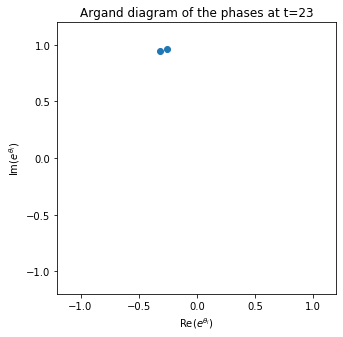

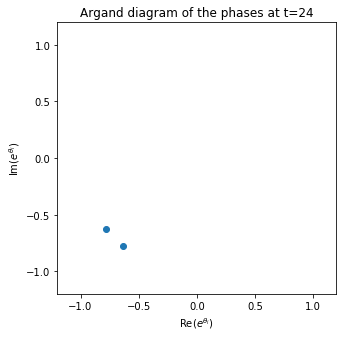

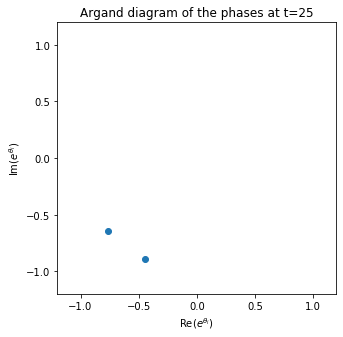

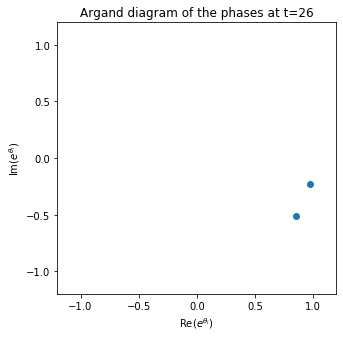

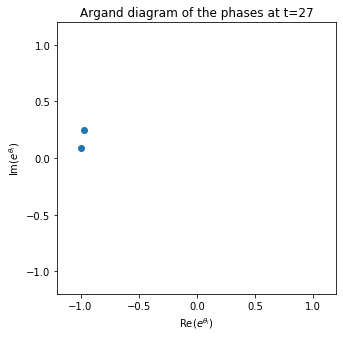

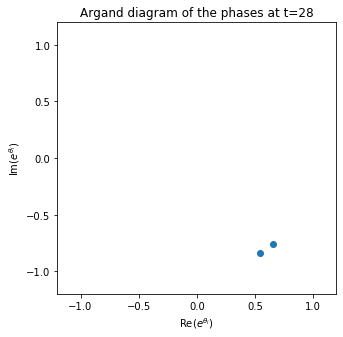

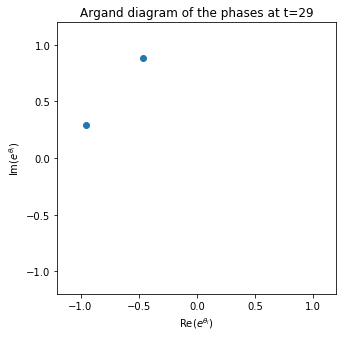

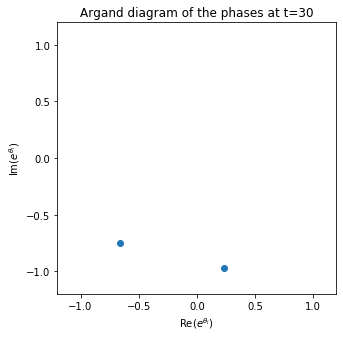

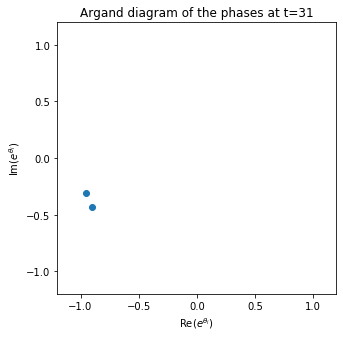

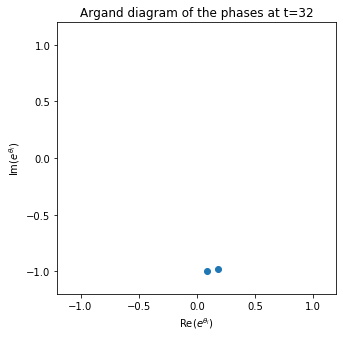

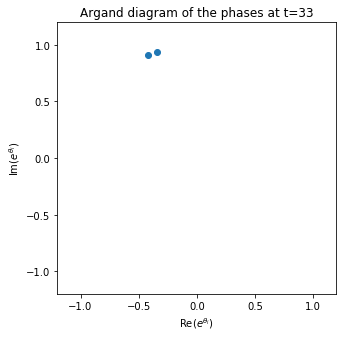

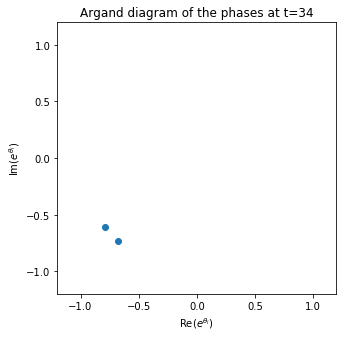

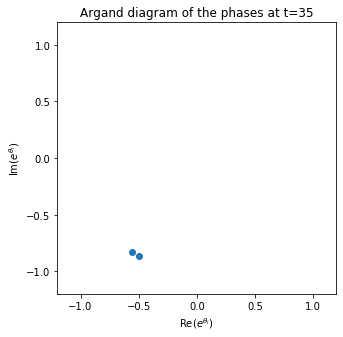

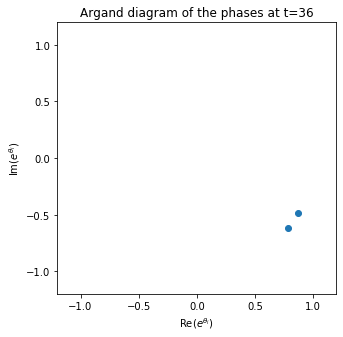

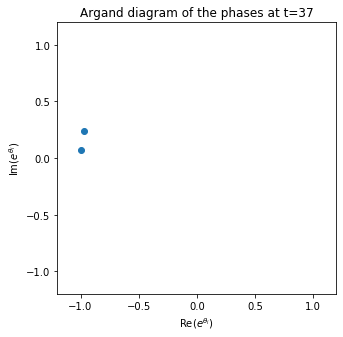

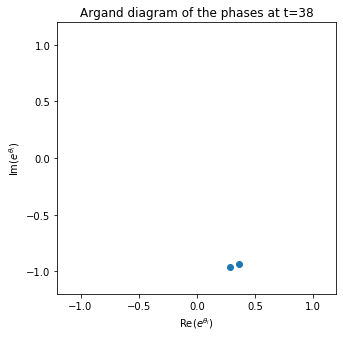

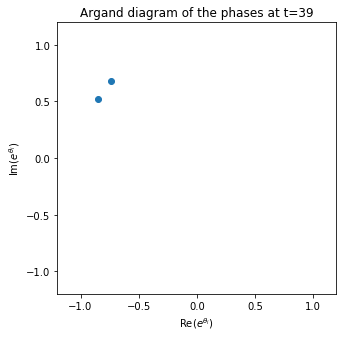

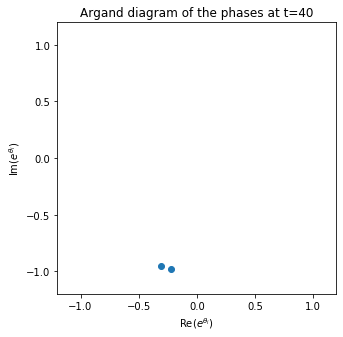

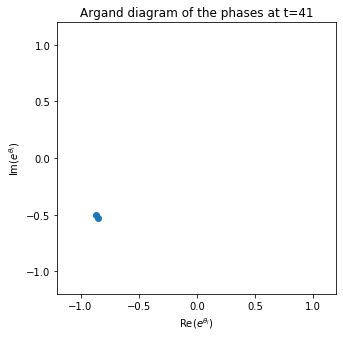

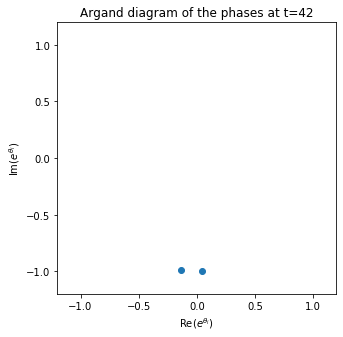

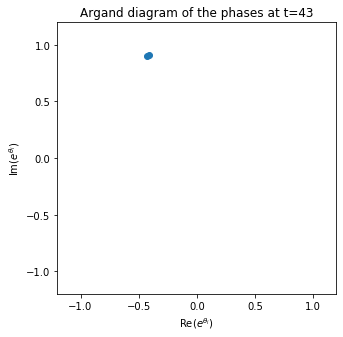

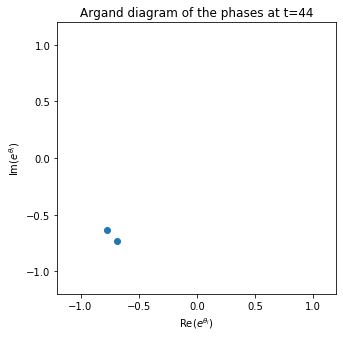

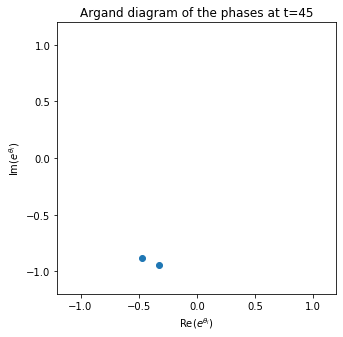

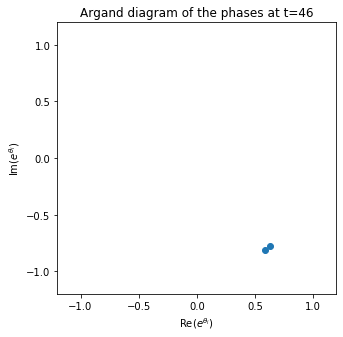

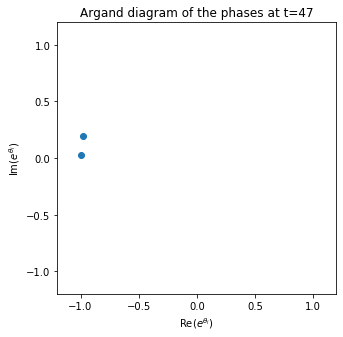

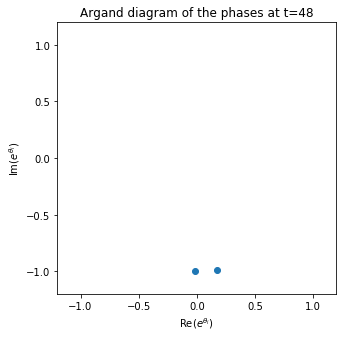

In [37]:
#Here we obtain argand diagrams
argand_times = range(int(max(t1)))
for k in argand_times:
    get_argand_diagrams(N,y1,k)

In [38]:
# <- The following function allows one to plot the evolution of the phases of a given number of oscillators ->
# <- You plug in the parameters and the number of figures; The number of figures is the number of simulations run ->
# <- the figurenumber should be given in the form (x,y) as the function will create an x by y mosaic of plots ->
# <- make sure that the path you ask the function to save the figure in is accessible; otherwise, you will see plots
# but you will also get an error and the plot will obviously not be saved ->
#<- The options legend and title should be set to True for 2 or 3 oscillators only; otherwise things get cluttered ->

In [39]:
def get_plots_for_low_N(N,K,h,D,tau,dt,tf,figurenumber,filename,path=defaultpath,figuresize=(25,12),legend=False,title=False,output=False):
    modelparameters=[N,K,h,D,tf,tau,dt]
    print("You have elected to use: N={},K={},h={},D={},tf={},tau={}".format(N,K,h,D,tf,tau))
    fn1,fn2=figurenumber
    fig = plt.figure(figsize=figuresize)
    for figno in range(figurenumber[0]*figurenumber[1]):
        omegais = rnd.uniform(0,2*np.pi,size=N)
        omega1=omegais[0]
        omega2=omegais[1]
        if(N>2):
            omega3=omegais[2]
        theta0s=rnd.uniform(0,2*np.pi,size=N)
        t1,y1 = integrate_euler(modelparameters,theta0s,omegais,t0=0)
        frame = fig.add_subplot(fn1,fn2,figno+1)
        for k in range(N):
            frame.plot(t1,y1[:,k],label="Numerical solution for phase of oscillator {}".format(k+1))
        frame.set_xlabel("Time [s]",fontsize=40)
        frame.set_ylabel("Phases [rad]",fontsize=40)
        frame.set_xlim(tau,max(t1))
        frame.set_ylim(y1.min()-2,y1.max()+2)
        frame.tick_params(axis='both',labelsize=40)
        frame.annotate("K={},h={},D={},$\\tau$={}".format(K,h,D,tau),(tau,y1.min()-1),fontsize=20)
        if(legend):
            frame.legend(loc="lower right")
        if(title):
            if(N ==2):
                frame.set_title("$\omega_1 = {:2f}$,$\omega_2={:1f}$".format(omega1,omega2),fontsize=40)
            elif(N==3):
                frame.set_title("$\omega_1 = {:2f}$,$\omega_2={:1f}$,$\omega_3={:1f}$".format(omega1,omega2,omega3))
            else:
                frame.set_title("Time-evolution of the oscillator phases for N = {} oscillators".format(N),fontsize=40)
        if(output):
            if(figurenumber==(1,1)):
                #fig.savefig(path+filename+".png")
                fig.savefig(path+filename+"_N{}".format(N)+"_K{}".format(K)+"_D{}_".format(D)+"h{}_".format(h)+"tau{}_".format(tau)+"tf{}_".format(tf)+"dt{}".format(dt)+".png")
                return (t1,y1)
    fig.savefig(path+filename+"_N{}".format(N)+"_K{}".format(K)+"_D{}_".format(D)+"tau{}_".format(tau)+"tf{}_".format(tf)+"dt{}".format(dt)+".png")

In [40]:
# Signature is get_plots_for_low_N(Number, K constant, forcing strength, Noise parameter, delay, time step, final time
# figure number in format (x,y), path as a string and filename as a string WITHOUT the / or \, figuresize as (x,y)
#legend and title bool) 

You have elected to use: N=100,K=10,h=1,D=1,tf=30,tau=1
Using K = 10 N = 100



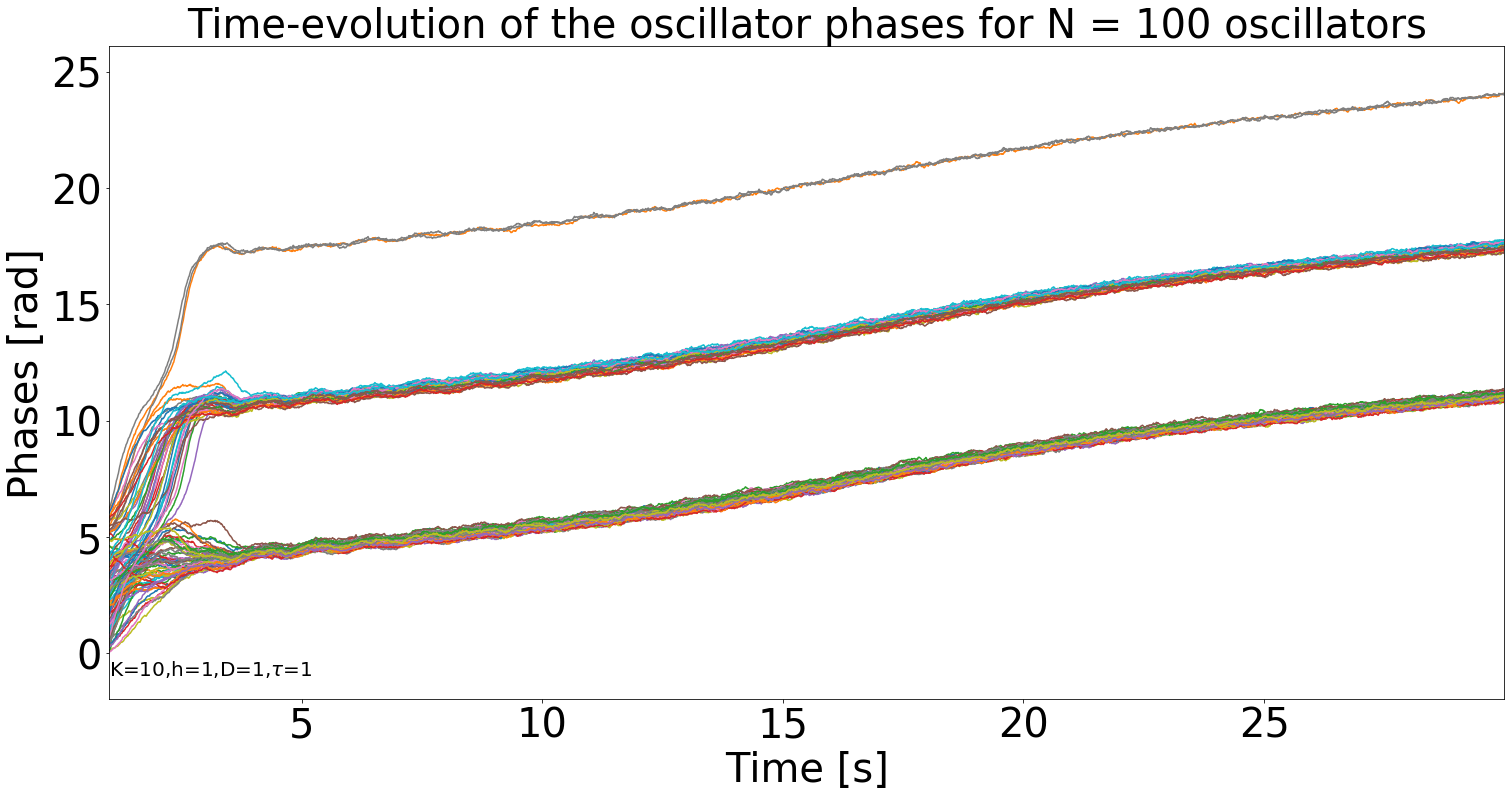

In [41]:
t2,y2 = get_plots_for_low_N(100,10,1,1,1,1e-2,30,(1,1),'catz',title=True,legend=False,output=True)

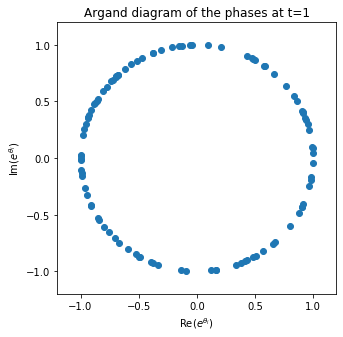

In [42]:
argand_times = [1]
for k in argand_times:
    get_argand_diagrams(N,y2,k)

In [44]:
### And now the ultimate function; simply put in the desired parameters, the desired output filename and you
### shall receive all the plots you want, neatly named. 
### The argument output controls whether you also get the dataset and associated times
### The argument argandtimes can be used to specify times for which the Argand diagram should be generated
### Use it as argandtimes=[time1,time2,time3,...,timeN] 

In [45]:
def simulate_all(N=1,K=1,h=1,D=1,tau=1,tf=20,dt=1e-2,filename="sim",path=defaultpath,argandtimes = "default",output=False):
    t1,y1=get_plots_for_low_N(N,K,h,D,tau,dt,tf,(1,1),filename,title=True,legend=False,output=True)
    if(argandtimes=="default"):
        argand_times = range(int(max(t1)))
    else:
        argand_times = argandtimes
    params=[K,h,D,tau,tf,dt]
    for k in argand_times:
        get_argand_diagrams_systematic(N,y1,k,params,filename=filename)
    fname = filename+"OrderParameter_"+"_N{}".format(N)+"_K{}".format(K)+"_D{}_".format(D)+"tau{}_".format(tau)+"tf{}_".format(tf)+"dt{}".format(dt)
    get_order_parameter_plot_from_dataset((t1,y1),params,filename=fname)
    if(output):
        return (t1,y1)

You have elected to use: N=50,K=12.5,h=0.0,D=10,tf=20,tau=1
Using K = 12.5 N = 50



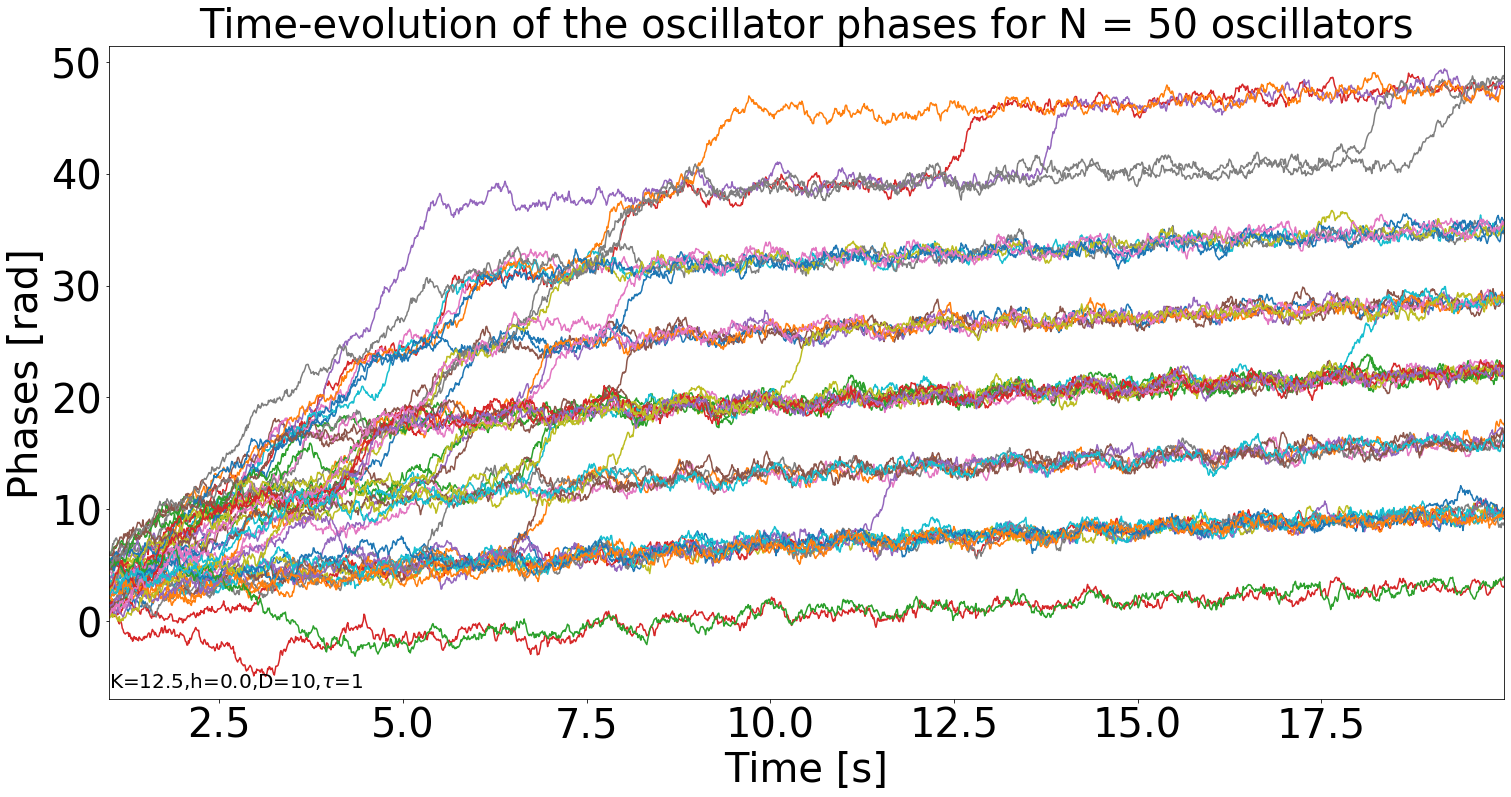

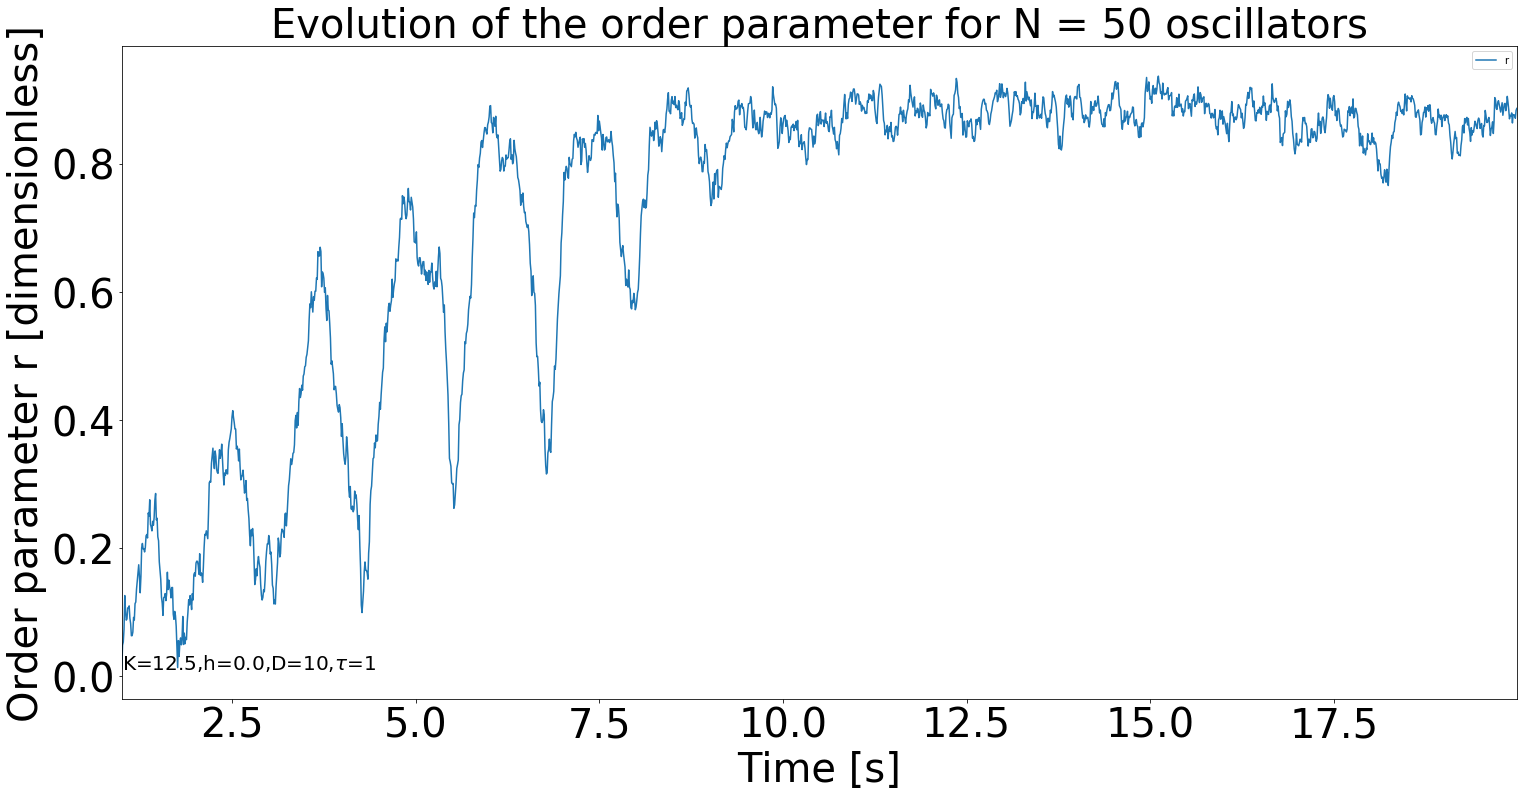

In [46]:
simulate_all(N=50,K=12.5,h=0.0,D=10,tau=1,tf=20,dt=1e-2,argandtimes=[0],filename="FullModel2")